In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *
from processing import *
from metrics import *
import datetime
from implementations import *
from training import *

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Adjust the path to where your data is stored
data_path = 'data/dataset/'

# Load the data
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path)

In [3]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (328135, 321)
y_train shape: (328135,)
x_test shape: (109379, 321)


# Without Balancing

## 1. Getting rid of non-necessary features (manual way)

In [4]:
# Define the columns to remove based on zero-based indexing
columns_to_remove = np.concatenate((
    np.arange(0, 26),    # 1st to 25th
    np.arange(54, 57),   # 54th to 56th
))

# Ensure that the columns_to_remove are unique and sorted
columns_to_remove = np.unique(columns_to_remove)
columns_to_remove.sort()

print(f"Total columns to remove: {len(columns_to_remove)}")
print(f"Columns indices to remove: {columns_to_remove}")

# Remove the specified columns from x_train and x_test
x_train_reduced = np.delete(x_train, columns_to_remove, axis=1)
x_test_reduced = np.delete(x_test, columns_to_remove, axis=1)

print(f'x_train_reduced shape: {x_train_reduced.shape}')
print(f'x_test_reduced shape: {x_test_reduced.shape}')

Total columns to remove: 29
Columns indices to remove: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 54 55 56]
x_train_reduced shape: (328135, 292)
x_test_reduced shape: (109379, 292)


## 2. Handling NaNs

### 2.1 Identifying NaNs

In [5]:
x_train_replace, x_test_replace = replace_placeholders_with_nan(x_train_reduced, x_test_reduced)

### 2.2 Removing Features with Too Many NaNs

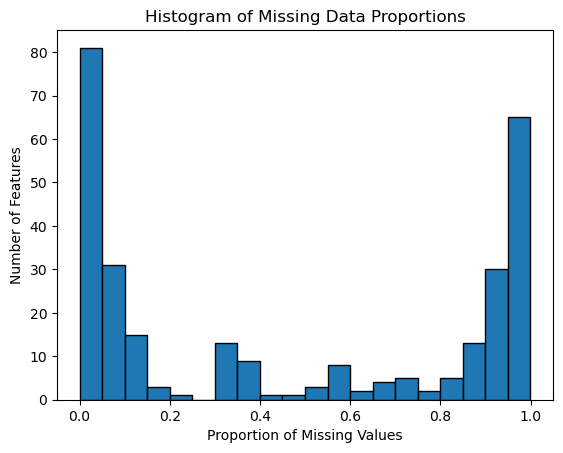

In [6]:
# we first compute the proportion of nanValues for each feature
nan_counts = np.isnan(x_train_replace).sum(axis=0)
propMissVals = nan_counts/x_train_replace.shape[0]

plt.hist(propMissVals, bins=20, edgecolor='k')
plt.title('Histogram of Missing Data Proportions')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Number of Features')
plt.show()

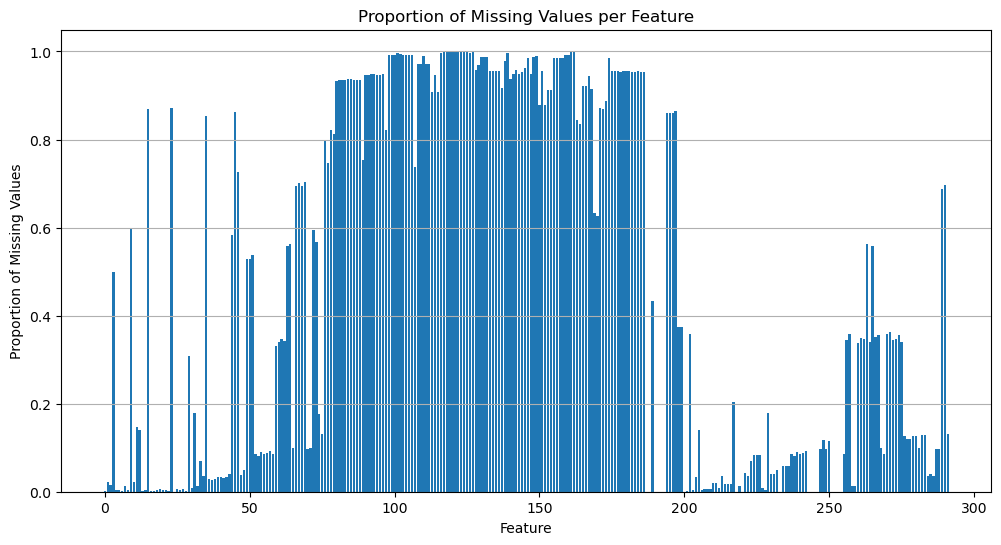

In [7]:
missing_proportions = np.mean(np.isnan(x_train_replace), axis=0)
plt.figure(figsize=(12, 6))
plt.bar(np.arange(x_train_replace.shape[1]), missing_proportions)
plt.title('Proportion of Missing Values per Feature')
plt.xlabel('Feature')
plt.ylabel('Proportion of Missing Values')
plt.grid(True, axis='y')
plt.show()

In [8]:
thresholds = np.arange(0, 1.05, 0.05)
for t in thresholds:
    num_features = np.sum(propMissVals <= t)
    print(f'Threshold: {t*100:.1f}%, Number of features retained: {num_features}')

Threshold: 0.0%, Number of features retained: 16
Threshold: 5.0%, Number of features retained: 81
Threshold: 10.0%, Number of features retained: 112
Threshold: 15.0%, Number of features retained: 127
Threshold: 20.0%, Number of features retained: 130
Threshold: 25.0%, Number of features retained: 131
Threshold: 30.0%, Number of features retained: 131
Threshold: 35.0%, Number of features retained: 144
Threshold: 40.0%, Number of features retained: 153
Threshold: 45.0%, Number of features retained: 154
Threshold: 50.0%, Number of features retained: 155
Threshold: 55.0%, Number of features retained: 158
Threshold: 60.0%, Number of features retained: 166
Threshold: 65.0%, Number of features retained: 168
Threshold: 70.0%, Number of features retained: 172
Threshold: 75.0%, Number of features retained: 177
Threshold: 80.0%, Number of features retained: 179
Threshold: 85.0%, Number of features retained: 184
Threshold: 90.0%, Number of features retained: 197
Threshold: 95.0%, Number of feature

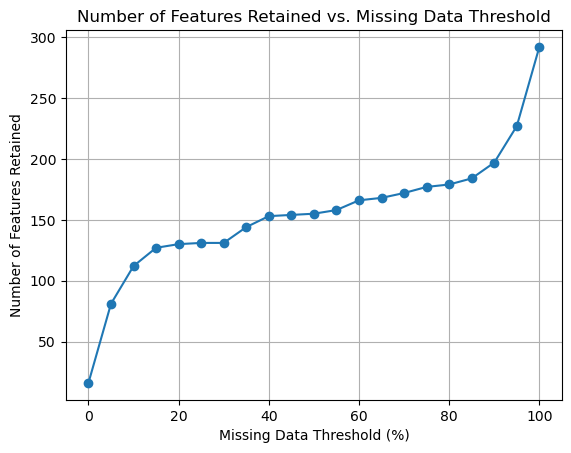

In [9]:
feature_counts = []

for t in thresholds:
    num_features = np.sum(propMissVals <= t)
    feature_counts.append(num_features)

# Plotting the results
plt.plot(thresholds * 100, feature_counts, marker='o')
plt.title('Number of Features Retained vs. Missing Data Threshold')
plt.xlabel('Missing Data Threshold (%)')
plt.ylabel('Number of Features Retained')
plt.grid(True)
plt.show()

In [10]:
# removing columns with more than 80% of NaN values
x_train_clean = x_train_replace.copy()
x_test_clean = x_test_replace.copy()

x_train_clean, columns_to_keep = remove_nan(x_train_clean, 0.80)
print(f"Shape of the new training set: {x_train_clean.shape}")

x_test_clean = x_test_clean[:, columns_to_keep]
print(f"Shape of the new test set: {x_test_clean.shape}")

Shape of the new training set: (328135, 179)
Shape of the new test set: (109379, 179)


### 2.3 Identifying Categorical and Continuous features

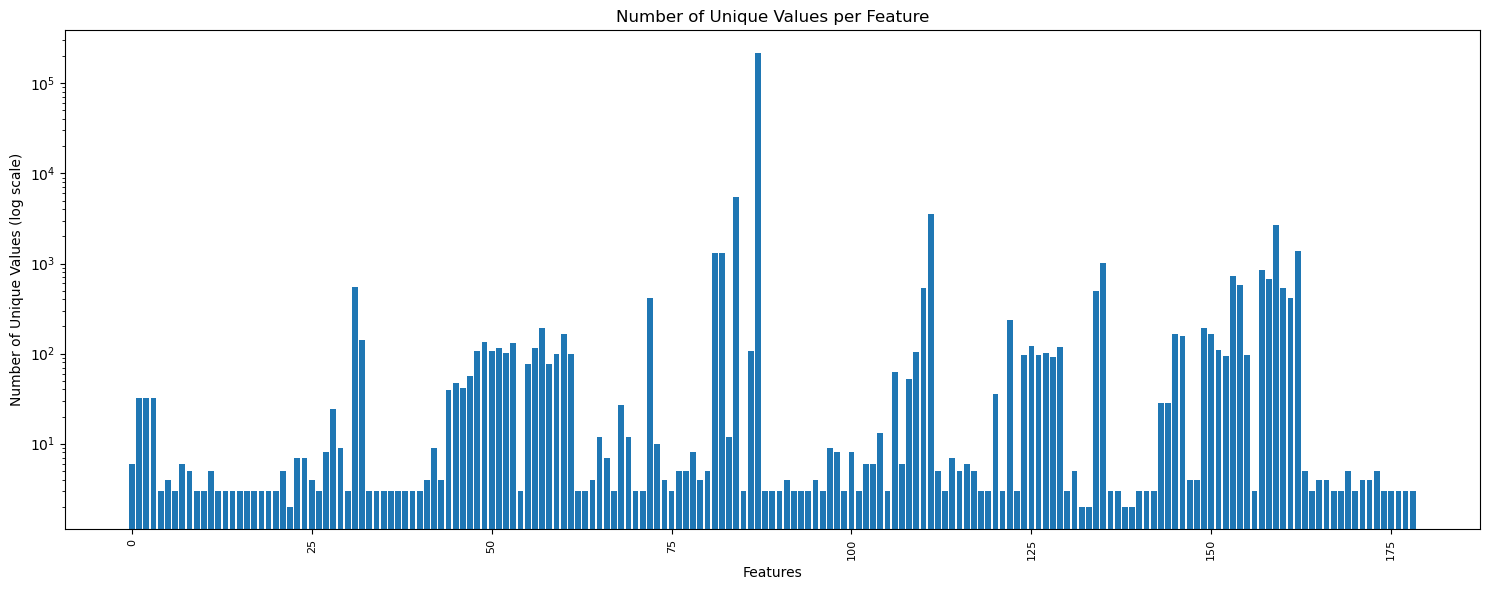

In [11]:
# Data used : x_train_clean and x_test_clean

# Calculate the number of unique values per feature
unique_counts = np.array([len(np.unique(x_train_clean[:, i])) for i in range(x_train_clean.shape[1])])

features = [i for i in range(x_train_clean.shape[1])]

plt.figure(figsize=(15, 6))
plt.bar(features, unique_counts)
plt.yscale('log')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Features')
plt.ylabel('Number of Unique Values (log scale)')
plt.title('Number of Unique Values per Feature')
plt.tight_layout()
plt.show()

In [12]:
categorical_features, continuous_features = classify_features(x_train_clean, threshold=10)

# Display the classification results
print(f'Number of Categorical Features: {len(categorical_features)}')
print(f'Number of Continuous Features: {len(continuous_features)}')

Number of Categorical Features: 113
Number of Continuous Features: 66


### 2.4 Handling NaNs

In [13]:
# Impute missing values in continuous features with median
x_train_impVal, x_test_impVal = impute_median_for_continuous_features(x_train_clean, x_test_clean, continuous_features)

In [14]:
# Impute mode for categorical features in training and test data
x_train_impVal = impute_mode(x_train_impVal, categorical_features)
x_test_impVal = impute_mode(x_test_impVal, categorical_features)

## 3. Correlation Analysis

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


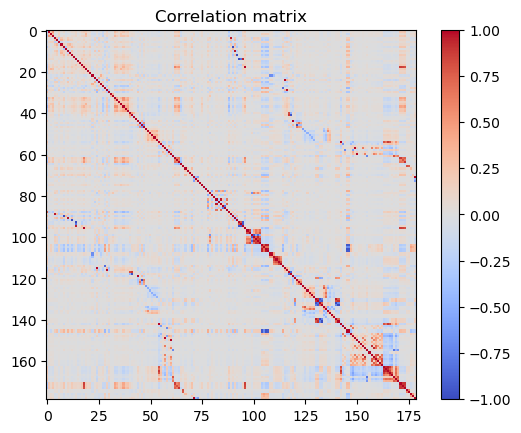

In [15]:
correlation_matrix = compute_corr(x_train_impVal)
plot_corr_matrix(correlation_matrix)

In [16]:
filtered_train, kept_features = remove_correlated_features(x_train_impVal, correlation_matrix, 0.75)
print(f"Shape of the new training set: {filtered_train.shape}")

filtered_test = x_test_impVal[:, kept_features]
print(f"Shape of the new test set: {filtered_test.shape}")

Shape of the new training set: (328135, 127)
Shape of the new test set: (109379, 127)


## 4. Removing Features with Low Variance

In [17]:
# Let's use a threshold of 0.1
x_train_selected, x_test_selected = variance_threshold(filtered_train, filtered_test, threshold=0.1)
print(f'Training data shape after Variance Thresholding: {x_train_selected.shape}')
print(f'Test data shape after Variance Thresholding: {x_test_selected.shape}')

Training data shape after Variance Thresholding: (328135, 101)
Test data shape after Variance Thresholding: (109379, 101)


## 5. Standardization

In [26]:
categorical_features, continuous_features = classify_features(x_train_selected, threshold=10)

x_train_std, x_test_std = standardize_features(x_train_selected, x_test_selected, continuous_features)

## 6. Adding Bias Term

In [27]:
x_train_unbalanced = add_bias_term(x_train_std)
x_test_unbalanced = add_bias_term(x_test_std)

In [28]:
np.savetxt("x_train_unbalanced.csv", x_train_unbalanced, delimiter=",")
np.savetxt("x_test_unbalanced.csv", x_test_unbalanced, delimiter=",")

# With Balancing

## 4. Balancing with SMOTE

In [18]:
# Identify majority and minority classes
classes, counts = np.unique(y_train, return_counts=True)
if counts[0] > counts[1]:
    majority_class = classes[0]
    minority_class = classes[1]
else:
    majority_class = classes[1]
    minority_class = classes[0]

In [19]:
x_train_smote, y_train_smote = smote(x_train_selected, y_train, minority_class)

print(f"Original dataset shape: {x_train_selected.shape}, {y_train.shape}")
print(f"SMOTE applied dataset shape: {x_train_smote.shape}, {y_train_smote.shape}")

Generating 270185 synthetic samples.
Original dataset shape: (328135, 101), (328135,)
SMOTE applied dataset shape: (598320, 101), (598320,)


## 5. Standardization

In [21]:
categorical_features_smote, continuous_features_smote = classify_features(x_train_smote, threshold=10)

x_train_std_smote, x_test_std_smote = standardize_features(x_train_smote, x_test_selected, continuous_features_smote)

## 6. Adding Bias Term

In [22]:
x_train_balanced = add_bias_term(x_train_std_smote)
x_test_balanced = add_bias_term(x_test_std_smote)

In [23]:
np.savetxt("x_train_balanced.csv", x_train_balanced, delimiter=",")
np.savetxt("x_test_balanced.csv", x_test_balanced, delimiter=",")

In [24]:
np.savetxt("y_train_balanced.csv", y_train_smote, delimiter=",")

# Running the best model

## Ridge Regression using normal equations (MSE) with lambda = 10e-5, degree = 1.

In [60]:
# RIDGE REGRESSION

lambda_values = [0.00001]
degrees = [1]

y_test_pred_ridge_balanced = evaluate_ridge_regression(
    y_train_smote,
    x_train_balanced,
    lambda_values,
    x_train_unbalanced,
    y_train,
    x_test_unbalanced,
    degrees,
    0.3,
    0
)

# Create CSV for AICrowd
create_csv_submission(test_ids, y_test_pred_ridge_balanced, "predictioncs_ridge_balanced.csv")

Starting grid search for Ridge Regression with feature expansion...

Feature Expansion Degree = 1
  For lambda = 1e-05
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
    Loss on training (w/ cross validation): 0.3035
      Validation Metrics:
          Accuracy : 0.7974
          Precision: 0.7679
          Recall   : 0.8520
          F1-score : 0.8078
      Original Training Set Metrics:
          Accuracy : 0.8926
          Precision: 0.3749
          Recall   : 0.3233
          F1-score : 0.3472
--------------------------------------------------------------------------------
